In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# Imports Scikit-Learn (Vus au TD Classification)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Ajout du chemin vers tes scripts personnels et ceux du prof
# Assure-toi que le dossier contenant libsigma est bien ici
sys.path.append('/home/onyxia/work/') 

from libsigma import read_and_write as rw
from libsigma import classification as cla
# Tu devras créer ce fichier pour tes fonctions perso comme demandé dans le projet
#import my_function as mf 

# Configuration des dossiers
data_dir = "data/"
results_dir = "results/"
fig_dir = os.path.join(results_dir, "figure/")

# Création des dossiers de sortie si inexistants (Bonne pratique TD)
os.makedirs(fig_dir, exist_ok=True)

print("Environnement chargé.")

Image référence : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif
Shapefile : /home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp

--- Analyse des Polygones ---


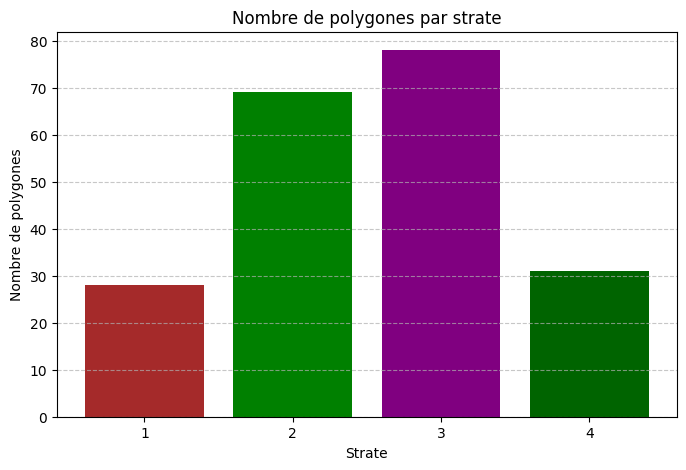


--- Rasterisation du Shapefile ---


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


✅ Rasterisation terminée : /home/onyxia/work/data/projet_eval/sample_strata.tif

--- Analyse des Pixels ---


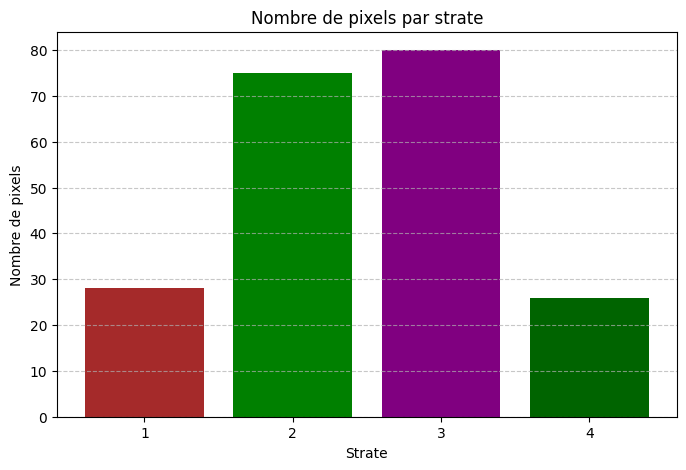

Classe 1: 28 pixels
Classe 2: 75 pixels
Classe 3: 80 pixels
Classe 4: 26 pixels


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal, ogr
# On utilise tes imports libsigma
from libsigma import read_and_write as rw

# ==============================================================================
# 1. CONFIGURATION DES CHEMINS
# ==============================================================================
# Chemins basés sur ta configuration
image_ref_path = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif'
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
output_raster = '/home/onyxia/work/data/projet_eval/sample_strata.tif'
fig_dir = 'results/figure' # Dossier pour sauver les graphiques
os.makedirs(fig_dir, exist_ok=True)

print(f"Image référence : {image_ref_path}")
print(f"Shapefile : {shp_path}")

# ==============================================================================
# 2. ANALYSE DES POLYGONES (Avec GeoPandas)
# ==============================================================================
print("\n--- Analyse des Polygones ---")
gdf = gpd.read_file(shp_path)

# On suppose la colonne 'strate' (vérifie si c'est 'classe' ou 'strate' avec gdf.head())
col_classe = 'strate' 
counts_poly = gdf[col_classe].value_counts().sort_index()

# Graphique Nombre de Polygones
plt.figure(figsize=(8, 5))
# Dictionnaire de couleurs pour harmoniser tout le projet
colors_dict = {1: 'brown', 2: 'green', 3: 'purple', 4: 'darkgreen'} 
colors_list = [colors_dict.get(i, 'gray') for i in counts_poly.index]

plt.bar(counts_poly.index.astype(str), counts_poly.values, color=colors_list)
plt.title(f"Nombre de polygones par strate")
plt.xlabel("Strate")
plt.ylabel("Nombre de polygones")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(fig_dir, "diag_baton_nb_poly_by_class.png"))
plt.show()

# ==============================================================================
# 3. RASTERISATION (Ton code GDAL)
# ==============================================================================
print("\n--- Rasterisation du Shapefile ---")

# a. Récupération infos image référence
raster_ds = gdal.Open(image_ref_path)
if raster_ds is None:
    print(f"ERREUR : Impossible d'ouvrir {image_ref_path}")
else:
    geotransform = raster_ds.GetGeoTransform()
    projection = raster_ds.GetProjection()
    x_size = raster_ds.RasterXSize
    y_size = raster_ds.RasterYSize
    raster_ds = None # Fermeture ref

    # b. Création du raster vide
    driver = gdal.GetDriverByName('GTiff')
    # On écrase si existe déjà
    if os.path.exists(output_raster):
        os.remove(output_raster)
        
    target_ds = driver.Create(output_raster, x_size, y_size, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    target_ds.SetProjection(projection)

    # c. Ouverture vecteur et Rasterisation
    shp_ds = ogr.Open(shp_path)
    layer = shp_ds.GetLayer()
    
    # "Brûlage" des polygones (ATTRIBUTE=strate)
    gdal.RasterizeLayer(target_ds, [1], layer, options=[f"ATTRIBUTE={col_classe}"])

    # d. Fermeture / Sauvegarde
    target_ds.FlushCache()
    target_ds = None
    shp_ds = None
    print(f"✅ Rasterisation terminée : {output_raster}")

# ==============================================================================
# 4. ANALYSE DES PIXELS (Avec Numpy/Matplotlib)
# ==============================================================================
print("\n--- Analyse des Pixels ---")

# Chargement du résultat
arr_samples = rw.load_img_as_array(output_raster)

# Comptage (np.unique)
classes, pixel_counts = np.unique(arr_samples, return_counts=True)

# On filtre pour ne pas compter le fond (0)
mask = classes != 0
classes_reelles = classes[mask]
counts_reels = pixel_counts[mask]

# Graphique Nombre de Pixels
plt.figure(figsize=(8, 5))
colors_list_pix = [colors_dict.get(i, 'gray') for i in classes_reelles]

plt.bar(classes_reelles.astype(str), counts_reels, color=colors_list_pix)
plt.title(f"Nombre de pixels par strate")
plt.xlabel("Strate")
plt.ylabel("Nombre de pixels")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(fig_dir, "diag_baton_nb_pix_by_class.png"))
plt.show()

# Affichage textuel pour vérification
for c, count in zip(classes_reelles, counts_reels):
    print(f"Classe {c}: {count} pixels")

Dimensions du masque : (1655, 2103)
Ouverture des images : 
 - /home/onyxia/work/data/projet_eval/pyrenees_24-25_B03.tif
 - /home/onyxia/work/data/projet_eval/pyrenees_24-25_B05.tif
Succès. Nombre de bandes : 10


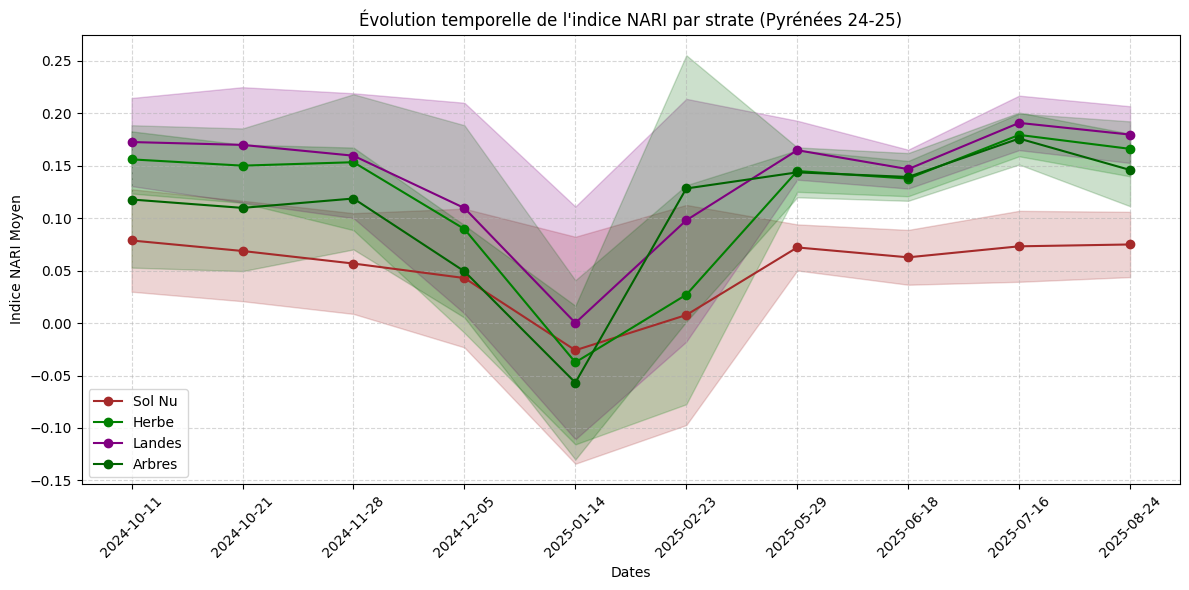

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
# On suppose que tu as importé libsigma comme 'rw' plus haut
from libsigma import read_and_write as rw

# ==============================================================================
# CONFIGURATION
# ==============================================================================

# 1. Tes dates
dates = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
         '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']

# 2. Chemins exacts (ABSOLUS)
# On utilise le chemin complet qui a fonctionné pour l'étape précédente
base_path = '/home/onyxia/work/data/projet_eval'
path_b03 = os.path.join(base_path, 'pyrenees_24-25_B03.tif')
path_b05 = os.path.join(base_path, 'pyrenees_24-25_B05.tif')

# Dictionnaires pour stocker les résultats
nari_means = {1: [], 2: [], 3: [], 4: []}
nari_stds = {1: [], 2: [], 3: [], 4: []}

# ==============================================================================
# PRÉPARATION DU MASQUE
# ==============================================================================

# On recharge le masque s'il n'est pas en mémoire (avec chemin absolu)
output_raster = os.path.join(base_path, 'sample_strata.tif')
if 'arr_samples' not in locals():
    print(f"Chargement du masque depuis : {output_raster}")
    arr_samples = rw.load_img_as_array(output_raster)

# Correction dimension (3D -> 2D)
if arr_samples.ndim == 3:
    arr_samples_2d = arr_samples[:, :, 0]
else:
    arr_samples_2d = arr_samples

print(f"Dimensions du masque : {arr_samples_2d.shape}")

# ==============================================================================
# CHARGEMENT ET CALCUL
# ==============================================================================

print(f"Ouverture des images : \n - {path_b03}\n - {path_b05}")

ds_b03 = rw.open_image(path_b03)
ds_b05 = rw.open_image(path_b05)

if ds_b03 is None or ds_b05 is None:
    print("ERREUR CRITIQUE : Fichiers introuvables. Vérifiez que les fichiers B03 et B05 existent bien dans le dossier.")
else:
    nb_bandes = ds_b03.RasterCount
    print(f"Succès. Nombre de bandes : {nb_bandes}")
    
    # Boucle sur les bandes
    for i in range(min(len(dates), nb_bandes)):
        date = dates[i]
        idx_gdal = i + 1
        
        try:
            b03 = ds_b03.GetRasterBand(idx_gdal).ReadAsArray().astype(np.float32)
            b05 = ds_b05.GetRasterBand(idx_gdal).ReadAsArray().astype(np.float32)
        except Exception as e:
            print(f"❌ Erreur lecture bande {idx_gdal} : {e}")
            continue

        # Calcul NARI
        with np.errstate(divide='ignore', invalid='ignore'):
            inv_b3 = 1 / b03
            inv_b5 = 1 / b05
            nari = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)
        
        # Extraction des stats par classe
        for c in [1, 2, 3, 4]:
            mask_class = (arr_samples_2d == c)
            
            # Gestion dimensions si léger décalage
            if nari.shape != mask_class.shape:
                 min_r = min(nari.shape[0], mask_class.shape[0])
                 min_c = min(nari.shape[1], mask_class.shape[1])
                 vals = nari[:min_r, :min_c][mask_class[:min_r, :min_c]]
            else:
                 vals = nari[mask_class]
                 
            vals = vals[~np.isnan(vals)]
            
            if len(vals) > 0:
                nari_means[c].append(np.mean(vals))
                nari_stds[c].append(np.std(vals))
            else:
                nari_means[c].append(np.nan)
                nari_stds[c].append(np.nan)

    ds_b03 = None
    ds_b05 = None

    # ==============================================================================
    # AFFICHAGE GRAPHIQUE
    # ==============================================================================

    plt.figure(figsize=(12, 6))
    colors = {1: 'brown', 2: 'green', 3: 'purple', 4: 'darkgreen'}
    labels = {1: 'Sol Nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbres'}
    
    x_axis = range(len(dates))

    for c in [1, 2, 3, 4]:
        mu = np.array(nari_means[c])
        sigma = np.array(nari_stds[c])
        
        if len(mu) == len(x_axis) and not np.all(np.isnan(mu)):
            plt.plot(x_axis, mu, label=labels[c], color=colors[c], marker='o')
            plt.fill_between(x_axis, mu - sigma, mu + sigma, color=colors[c], alpha=0.2)

    plt.xticks(x_axis, dates, rotation=45)
    plt.title("Évolution temporelle de l'indice NARI par strate (Pyrénées 24-25)")
    plt.xlabel("Dates")
    plt.ylabel("Indice NARI Moyen")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Dossier de sauvegarde (absolu aussi pour être sûr)
    save_dir = '/home/onyxia/work/projet_teledec/notebook/results/figure'
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, "ARI_series.png"))
    plt.show()

In [ ]:
import os
import numpy as np
from osgeo import gdal
from libsigma import read_and_write as rw

print("--- Création du fichier raster NARI (Série Temporelle) ---")

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
# Chemins des sources (B03 et B05)
base_path = '/home/onyxia/work/data/projet_eval'
path_b03 = os.path.join(base_path, 'pyrenees_24-25_B03.tif')
path_b05 = os.path.join(base_path, 'pyrenees_24-25_B05.tif')

# Chemin de sortie demandé par le sujet
out_nari_path = '/home/onyxia/work/projet_teledec/notebook/results/figure/ARI_serie_temp.tif'

# Valeur de NoData demandée
nodata_val = -9999

# ==============================================================================
# 2. PRÉPARATION DU FICHIER DE SORTIE
# ==============================================================================

# On ouvre un fichier source pour récupérer les dimensions et la projection
ds_src = gdal.Open(path_b03)
if ds_src is None:
    raise FileNotFoundError(f"Impossible d'ouvrir {path_b03}")

x_size = ds_src.RasterXSize
y_size = ds_src.RasterYSize
nb_bands = ds_src.RasterCount # Devrait être 10
geo_transform = ds_src.GetGeoTransform()
projection = ds_src.GetProjection()

# Création du fichier vide
# Format float32 demandé (GDT_Float32)
driver = gdal.GetDriverByName('GTiff')
if os.path.exists(out_nari_path):
    os.remove(out_nari_path)

print(f"Création de {out_nari_path} ({x_size}x{y_size}, {nb_bands} bandes, Float32)")

ds_out = driver.Create(out_nari_path, x_size, y_size, nb_bands, gdal.GDT_Float32)
ds_out.SetGeoTransform(geo_transform)
ds_out.SetProjection(projection)

# ==============================================================================
# 3. CALCUL ET ÉCRITURE BANDE PAR BANDE
# ==============================================================================

# On ouvre B05 également
ds_b05 = gdal.Open(path_b05)

for i in range(nb_bands):
    idx = i + 1 # GDAL commence à 1
    print(f"Traitement bande {idx}/{nb_bands}...", end='\r')
    
    # Lecture
    arr_b3 = ds_src.GetRasterBand(idx).ReadAsArray().astype(np.float32)
    arr_b5 = ds_b05.GetRasterBand(idx).ReadAsArray().astype(np.float32)
    
    # Calcul NARI : (1/B3 - 1/B5) / (1/B3 + 1/B5)
    # On initialise tout à NoData (-9999) pour gérer les divisions par zéro proprement
    nari = np.full(arr_b3.shape, nodata_val, dtype=np.float32)
    
    # On ne calcule que là où les pixels sont valides (> 0)
    valid_mask = (arr_b3 > 0) & (arr_b5 > 0)
    
    # Calcul vectorisé uniquement sur les pixels valides
    # Astuce : on évite les divisions par zéro grâce au masque
    # Mais par sécurité on utilise np.errstate
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_b3 = 1.0 / arr_b3[valid_mask]
        inv_b5 = 1.0 / arr_b5[valid_mask]
        
        res = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)
        
        # On remplit le tableau final
        nari[valid_mask] = res

    # Nettoyage des NaNs/Infs éventuels qui auraient pu passer
    nari[np.isnan(nari)] = nodata_val
    nari[np.isinf(nari)] = nodata_val

    # Écriture dans le fichier de sortie
    out_band = ds_out.GetRasterBand(idx)
    out_band.WriteArray(nari)
    out_band.SetNoDataValue(nodata_val)
    out_band.FlushCache() # Force l'écriture sur le disque

# ==============================================================================
# 4. FERMETURE
# ==============================================================================
ds_src = None
ds_b05 = None
ds_out = None

print(f"\n✅ Fichier sauvegardé : {out_nari_path}")

--- Création du fichier raster NARI (Série Temporelle) ---
Création de /home/onyxia/work/projet_teledec/notebook/results/figure/ARI_serie_temp.tif (2103x1655, 10 bandes, Float32)


Traitement bande 10/10...
✅ Fichier sauvegardé : /home/onyxia/work/projet_teledec/notebook/results/figure/ARI_serie_temp.tif


In [ ]:
import os
import numpy as np
from osgeo import gdal, ogr
from libsigma import classification as cla
from libsigma import read_and_write as rw

# ==============================================================================
# 1. RASTERISATION DES IDS DE POLYGONES (Pour les Groupes)
# ==============================================================================
print("--- Préparation des Groupes (IDs Polygones) ---")

# Chemins
image_ref_path = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif'
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
out_raster_ids = '/home/onyxia/work/data/projet_eval/PI_ids_rasterized.tif'
# Le fichier créé à l'étape 1
out_raster_samples = '/home/onyxia/work/data/projet_eval/sample_strata.tif' 

# a. Récupération infos image référence (dimensions et projection)
raster_ds = gdal.Open(image_ref_path)
geotransform = raster_ds.GetGeoTransform()
projection = raster_ds.GetProjection()
x_size = raster_ds.RasterXSize
y_size = raster_ds.RasterYSize
raster_ds = None # Fermeture

# b. Création du raster des IDs vide
# ATTENTION : On utilise GDT_UInt16 car les IDs dépassent souvent 255
driver = gdal.GetDriverByName('GTiff')
if os.path.exists(out_raster_ids): 
    os.remove(out_raster_ids)
    
target_ds = driver.Create(out_raster_ids, x_size, y_size, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(geotransform)
target_ds.SetProjection(projection)

# c. Rasterisation de la colonne 'id'
# ⚠️ VERIFIEZ : Si votre colonne s'appelle 'ID', 'fid' ou autre, changez "ATTRIBUTE=id" ci-dessous
shp_ds = ogr.Open(shp_path)
layer = shp_ds.GetLayer()
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=id"]) 

target_ds = None 
shp_ds = None
print(f"✅ Raster des IDs créé : {out_raster_ids}")

# ==============================================================================
# 2. CONSTRUCTION DE LA STACK X (Empilement des bandes & dates)
# ==============================================================================
print("\n--- Construction de la matrice X (Features) ---")

# Liste des bandes à utiliser (Les fichiers TIF multibandes)
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
base_dir = '/home/onyxia/work/data/projet_eval'
# Pattern du nom de fichier
file_pattern = "pyrenees_24-25_{}.tif"

# a. Chargement du masque d'échantillons (Où sont les pixels d'entraînement ?)
arr_samples = rw.load_img_as_array(out_raster_samples)
# Passage en 2D si besoin
if arr_samples.ndim == 3: arr_samples = arr_samples[:,:,0]

# b. Récupération des coordonnées des pixels (là où strate > 0)
pixel_locations = np.where(arr_samples > 0)
Y = arr_samples[pixel_locations] # Labels (Classes)

print(f"Nombre total de pixels échantillons : {Y.shape[0]}")

# c. Boucle sur les fichiers pour extraire X
X_list = []

for b_name in band_names:
    fname = os.path.join(base_dir, file_pattern.format(b_name))
    print(f"Extraction depuis : {fname} ...")
    
    # On charge tout le fichier (qui contient 10 dates)
    # img_arr sera de forme (Hauteur, Largeur, 10_dates)
    img_arr = rw.load_img_as_array(fname) 
    
    # Extraction magique avec Numpy : on prend les pixels aux coordonnées 'pixel_locations'
    # Cela extrait toutes les dates d'un coup pour ces pixels
    X_band = img_arr[pixel_locations[0], pixel_locations[1], :]
    
    X_list.append(X_band)

# d. Concaténation finale
# X aura la forme (N_pixels, 100) -> 10 fichiers * 10 dates
X = np.concatenate(X_list, axis=1)

print(f"✅ Matrice X construite. Dimensions : {X.shape}")
print(f"   (Lignes = Pixels, Colonnes = Variables)")

# ==============================================================================
# 3. EXTRACTION DES GROUPES
# ==============================================================================
print("\n--- Extraction des Groupes ---")

# On charge l'image des IDs créée au point 1
arr_ids = rw.load_img_as_array(out_raster_ids)
if arr_ids.ndim == 3: arr_ids = arr_ids[:,:,0]

# On extrait les IDs aux MÊMES endroits que les pixels échantillons
groups = arr_ids[pixel_locations]

print(f"✅ Groupes extraits. Dimensions : {groups.shape}")
print(f"   (Doit être identique à Y : {Y.shape})")

# Vérification finale
print("\n--- RÉSUMÉ ---")
print(f"X (Features) : {X.shape}")
print(f"Y (Labels)   : {Y.shape}")
print(f"Groups (IDs) : {groups.shape}")

--- Préparation des Groupes (IDs Polygones) ---
✅ Raster des IDs créé : /home/onyxia/work/data/projet_eval/PI_ids_rasterized.tif

--- Construction de la matrice X (Features) ---


Nombre total de pixels échantillons : 209
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B03.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B04.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B05.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B06.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B07.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B08.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B8A.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B11.tif ...
Extraction depuis : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B12.tif ...
✅ Matrice X construite. Dimensions : (209, 100)
   (Lignes = Pixels, Colonnes = Variables)

--- Extraction des Groupes ---
✅ Groupes extra


--- Recherche des meilleurs hyperparamètres (GridSearch) ---
Lancement de l'optimisation (peut prendre un peu de temps)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Meilleurs paramètres trouvés : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
✅ Meilleur score F1 (moyen sur CV) : 0.8515

--- Analyse des performances (sur l'ensemble des données) ---
              precision    recall  f1-score   support

      Sol Nu       1.00      1.00      1.00        28
       Herbe       1.00      1.00      1.00        75
      Landes       1.00      1.00      1.00        80
      Arbres       1.00      1.00      1.00        26

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209



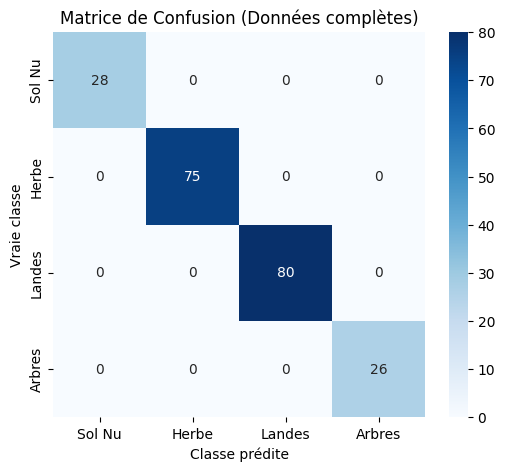


--- Importance des variables ---


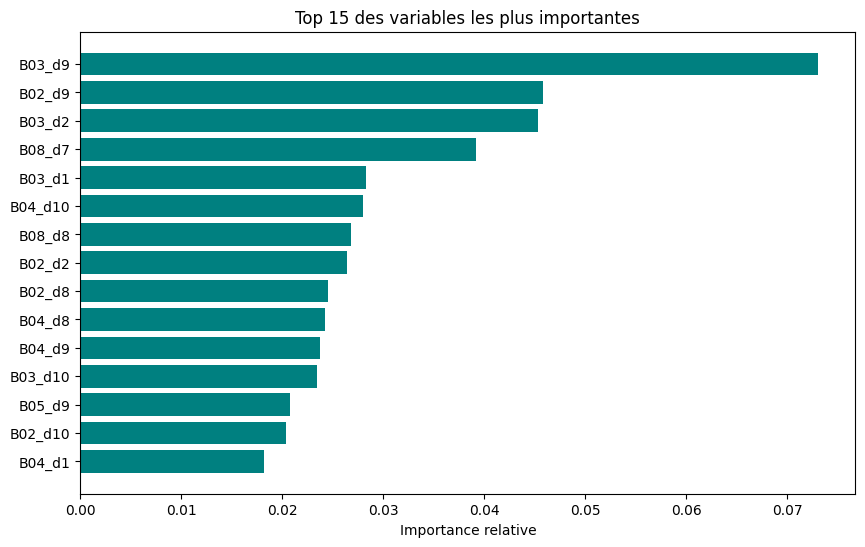

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns # Si tu l'as, sinon on fera avec matplotlib pur

# ==============================================================================
# 4. OPTIMISATION DES HYPERPARAMÈTRES (GridSearch + CV par Groupe)
# ==============================================================================
print("\n--- Recherche des meilleurs hyperparamètres (GridSearch) ---")

# a. Configuration du modèle et de la grille
rf = RandomForestClassifier(random_state=42)

# Grille demandée dans le sujet (Tableau 4)
# Tu peux ajuster les valeurs si le calcul est trop long, mais celles-ci sont standard
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_leaf': [1, 5],
    # 'max_features': ['sqrt', 'log2'] # Optionnel, par défaut c'est sqrt
}

# b. Stratégie de validation croisée
# C'est LA partie clé : on utilise les groupes pour ne pas séparer les pixels d'un même polygone
# n_splits=5 est standard. Si tu as une erreur car trop peu de données, essaie n_splits=3
cv = StratifiedGroupKFold(n_splits=5)

# c. Lancement de la recherche
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted', # On optimise le F1-score pondéré
    n_jobs=-1,             # Parallélisation (demandé dans "Pistes Techniques")
    verbose=1
)

# ATTENTION : On passe 'groups' ici !
print("Lancement de l'optimisation (peut prendre un peu de temps)...")
grid_search.fit(X, Y, groups=groups)

# d. Résultats
print(f"\n✅ Meilleurs paramètres trouvés : {grid_search.best_params_}")
print(f"✅ Meilleur score F1 (moyen sur CV) : {grid_search.best_score_:.4f}")

# On récupère le "champion" (le meilleur modèle)
best_clf = grid_search.best_estimator_

# ==============================================================================
# 5. ANALYSE DU MODÈLE FINAL
# ==============================================================================
print("\n--- Analyse des performances (sur l'ensemble des données) ---")
# Note : Idéalement on aurait un jeu de test séparé au tout début.
# Ici, on regarde comment le modèle final se comporte sur les données qu'il a vues.

Y_pred = best_clf.predict(X)

# Rapport de classification
print(classification_report(Y, Y_pred, target_names=['Sol Nu', 'Herbe', 'Landes', 'Arbres']))

# Matrice de confusion
cm = confusion_matrix(Y, Y_pred)

plt.figure(figsize=(6, 5))
# Affichage simple avec Matplotlib (si seaborn n'est pas dispo, dis-le moi)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sol Nu', 'Herbe', 'Landes', 'Arbres'],
            yticklabels=['Sol Nu', 'Herbe', 'Landes', 'Arbres'])
plt.title('Matrice de Confusion (Données complètes)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.savefig(os.path.join(fig_dir, "matrice_confusion.png"))
plt.show()

# ==============================================================================
# 6. IMPORTANCE DES VARIABLES (Feature Importance)
# ==============================================================================
print("\n--- Importance des variables ---")

importances = best_clf.feature_importances_
# On crée des noms pour les 100 variables : B02_date1, B02_date2...
# Rappel : band_names = ['B02', 'B03', ...] et il y a 10 dates par bande
noms_vars = []
for b in band_names: # Défini à l'étape précédente
    for i in range(10): # 10 dates
        noms_vars.append(f"{b}_d{i+1}")

# Création d'un petit DataFrame pour trier
import pandas as pd
df_imp = pd.DataFrame({'Variable': noms_vars, 'Importance': importances})
df_imp = df_imp.sort_values('Importance', ascending=False).head(15) # Top 15

# Graphique
plt.figure(figsize=(10, 6))
plt.barh(df_imp['Variable'], df_imp['Importance'], color='teal')
plt.gca().invert_yaxis() # La plus importante en haut
plt.title("Top 15 des variables les plus importantes")
plt.xlabel("Importance relative")
plt.savefig(os.path.join(fig_dir, "feature_importance.png"))
plt.show()


--- Importance des variables (Top 15 avec Dates) ---


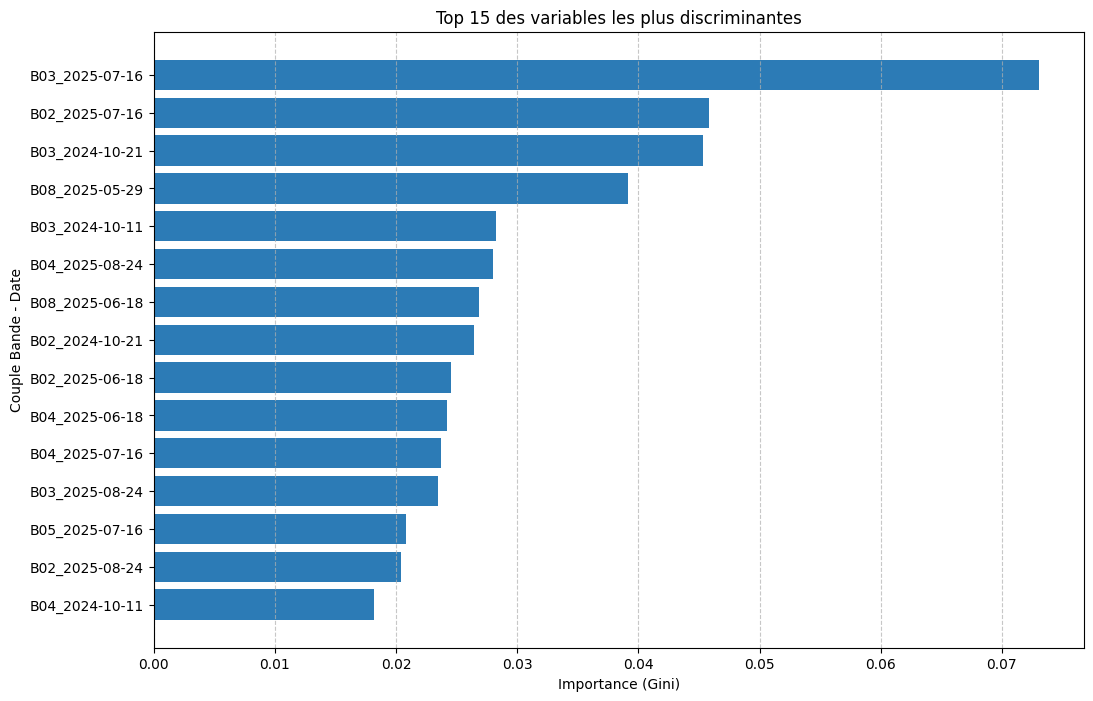

Variables les plus importantes :
      Variable  Importance
B03_2025-07-16    0.073091
B02_2025-07-16    0.045808
B03_2024-10-21    0.045366
B08_2025-05-29    0.039179
B03_2024-10-11    0.028277
B04_2025-08-24    0.027983
B08_2025-06-18    0.026848
B02_2024-10-21    0.026425
B02_2025-06-18    0.024503
B04_2025-06-18    0.024216
B04_2025-07-16    0.023747
B03_2025-08-24    0.023479
B05_2025-07-16    0.020808
B02_2025-08-24    0.020410
B04_2024-10-11    0.018185


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==============================================================================
# 6. IMPORTANCE DES VARIABLES (Avec les vraies dates)
# ==============================================================================
print("\n--- Importance des variables (Top 15 avec Dates) ---")

# 1. On rappelle les listes utilisées pour construire X
# (Doivent être identiques à celles utilisées dans l'étape précédente)
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
         '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']

# 2. Génération des noms de variables dans le bon ordre
# Ordre : Pour chaque Bande -> Toutes les dates
noms_vars_reels = []
for band in band_names:
    for date in dates:
        noms_vars_reels.append(f"{band}_{date}")

# Vérification de sécurité
importances = best_clf.feature_importances_
if len(noms_vars_reels) != len(importances):
    print(f"⚠️ Attention : {len(noms_vars_reels)} noms générés mais {len(importances)} variables dans le modèle.")
    # On coupe ou on adapte si besoin, mais normalement c'est bon (10 bandes * 10 dates = 100)
    noms_vars_reels = noms_vars_reels[:len(importances)]

# 3. Création du DataFrame et Tri
df_imp = pd.DataFrame({'Variable': noms_vars_reels, 'Importance': importances})
# On trie du plus important au moins important et on prend le Top 15
df_top15 = df_imp.sort_values('Importance', ascending=False).head(15)

# 4. Affichage Graphique
plt.figure(figsize=(12, 8))
# barh dessine du bas vers le haut, on inverse l'axe Y pour avoir le n°1 en haut
plt.barh(df_top15['Variable'], df_top15['Importance'], color='#2c7bb6')
plt.gca().invert_yaxis() 

plt.title("Top 15 des variables les plus discriminantes")
plt.xlabel("Importance (Gini)")
plt.ylabel("Couple Bande - Date")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Sauvegarde dans le dossier results/figure
save_path = '/home/onyxia/work/results/figure/feature_importance_dates.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, bbox_inches='tight')
plt.show()

# 5. Affichage textuel pour le rapport
print("Variables les plus importantes :")
print(df_top15.to_string(index=False))

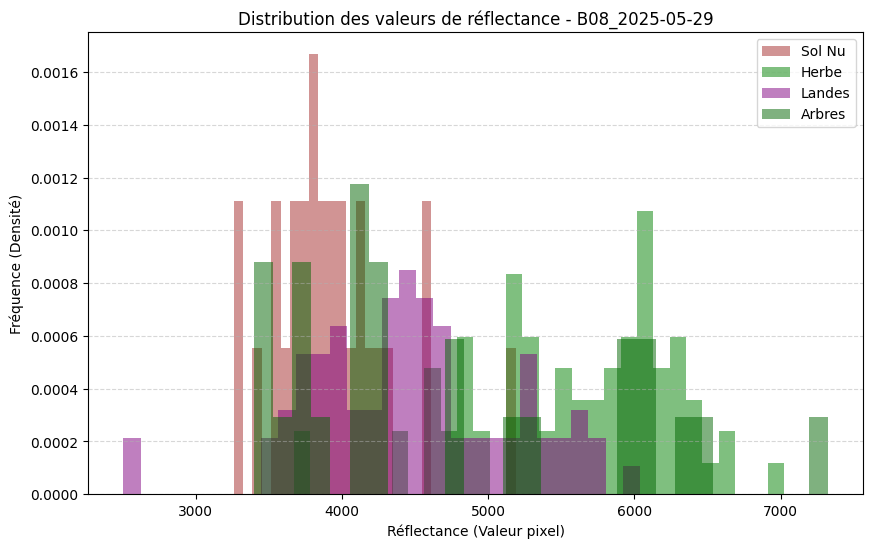

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration
# On choisit une bande et une date discriminante (ex: B08 en Mai/Juin)
# Rappel structure X : 10 blocs de 10 dates. 
# B08 est le 7ème bloc (index 6). Date '2025-05-29' est la 7ème (index 6).
# Index colonne = (Index_Bande * 10_Dates) + Index_Date
# B08 (idx 6) * 10 + Date 6 (idx 6) = 66
idx_col = 66 
nom_var = "B08_2025-05-29"

plt.figure(figsize=(10, 6))

colors = {1: 'brown', 2: 'green', 3: 'purple', 4: 'darkgreen'}
labels = {1: 'Sol Nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbres'}

# Boucle sur les classes pour tracer l'histogramme de chacune
for c in [1, 2, 3, 4]:
    # Sélection des pixels de la classe c
    mask = (Y == c)
    vals = X[mask, idx_col]
    
    # Histogramme (TD Visu : paramètre alpha pour transparence, density pour normaliser)
    plt.hist(vals, bins=30, alpha=0.5, label=labels[c], color=colors[c], density=True)

plt.title(f"Distribution des valeurs de réflectance - {nom_var}")
plt.xlabel("Réflectance (Valeur pixel)")
plt.ylabel("Fréquence (Densité)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Sauvegarde
plt.savefig("results/figure/histogramme_B08_Mai.png")
plt.show()

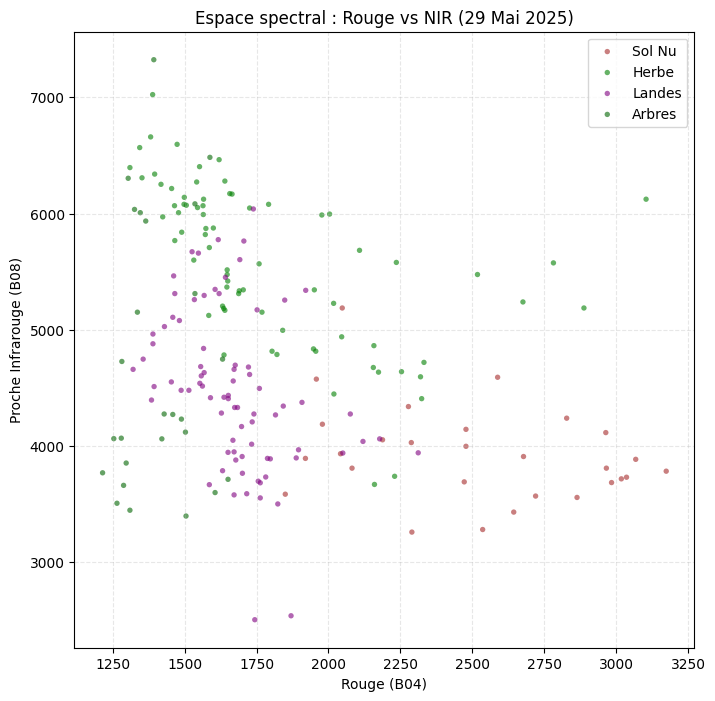

In [ ]:
# Configuration : Rouge (B04) vs NIR (B08) à la même date (Date 6 : 2025-05-29)
# B04 (idx 2) -> Col 20 à 29. Date 6 -> Index 26
# B08 (idx 6) -> Col 60 à 69. Date 6 -> Index 66
idx_red = 26
idx_nir = 66

plt.figure(figsize=(8, 8))

for c in [1, 2, 3, 4]:
    mask = (Y == c)
    x_vals = X[mask, idx_red] # Rouge
    y_vals = X[mask, idx_nir] # NIR
    
    # Scatter plot (TD Visu : marker='.', s=taille)
    plt.scatter(x_vals, y_vals, label=labels[c], color=colors[c], alpha=0.6, s=15, edgecolors='none')

plt.title("Espace spectral : Rouge vs NIR (29 Mai 2025)")
plt.xlabel("Rouge (B04)")
plt.ylabel("Proche Infrarouge (B08)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Sauvegarde
plt.savefig("results/figure/scatter_Red_NIR_Mai.png")
plt.show()

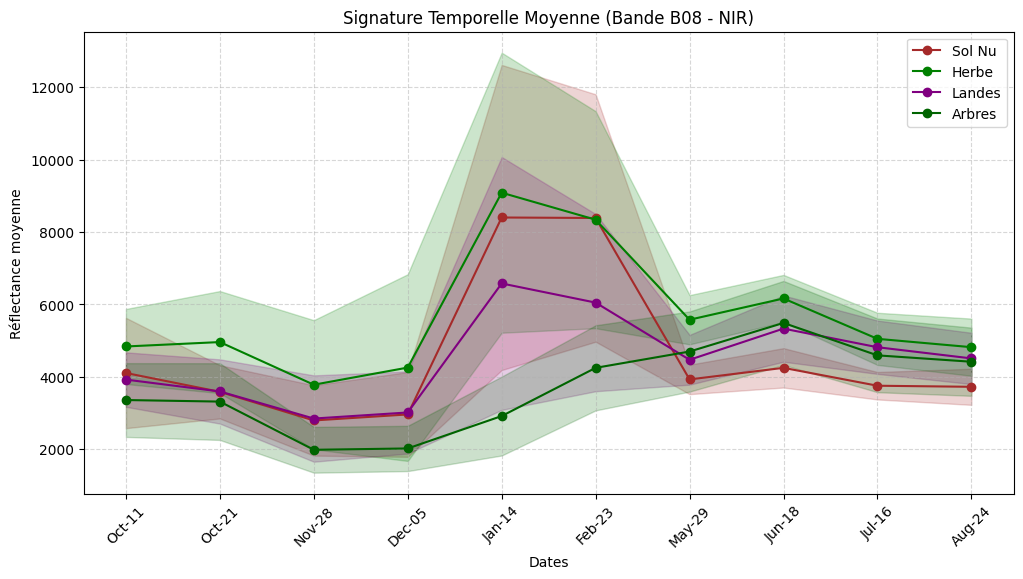

In [ ]:
# On veut récupérer les 10 colonnes correspondant à B08
# B08 est à l'index bande 6. Donc colonnes 60 à 69.
start_col = 60
end_col = 70
dates_labels = ['Oct-11', 'Oct-21', 'Nov-28', 'Dec-05', 'Jan-14', 'Feb-23', 'May-29', 'Jun-18', 'Jul-16', 'Aug-24']
x_axis = range(10)

plt.figure(figsize=(12, 6))

for c in [1, 2, 3, 4]:
    mask = (Y == c)
    # On prend toutes les dates pour la bande B08 pour la classe c
    # sub_X de forme (Nombre_pixels_classe, 10_dates)
    sub_X = X[mask, start_col:end_col]
    
    # Calcul Moyenne et Ecart-type par date (axis=0 -> colonne par colonne)
    means = np.mean(sub_X, axis=0)
    stds = np.std(sub_X, axis=0)
    
    # Plot moyenne
    plt.plot(x_axis, means, label=labels[c], color=colors[c], marker='o')
    
    # Ruban Ecart-type (fill_between)
    plt.fill_between(x_axis, means - stds, means + stds, color=colors[c], alpha=0.2)

plt.title("Signature Temporelle Moyenne (Bande B08 - NIR)")
plt.xlabel("Dates")
plt.ylabel("Réflectance moyenne")
plt.xticks(x_axis, dates_labels, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Sauvegarde
plt.savefig("results/figure/signature_temporelle_B08.png")
plt.show()

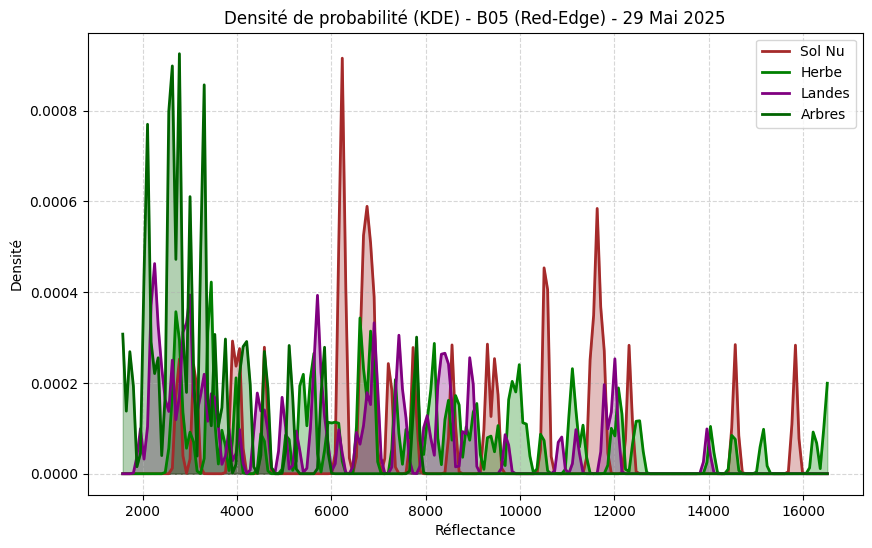

In [ ]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np

# Configuration : On regarde le RED-EDGE (B05) en Mai (Date 6 -> 29 Mai)
# B05 est la 4ème bande (index 3). Date 6 (index 5).
# Index colonne = 3 * 10 + 5 = 35
idx_col = 35
nom_var = "B05 (Red-Edge) - 29 Mai 2025"

plt.figure(figsize=(10, 6))

colors = {1: 'brown', 2: 'green', 3: 'purple', 4: 'darkgreen'}
labels = {1: 'Sol Nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbres'}

# On génère une ligne de X pour le tracé (de la valeur min à max de la bande)
x_plot = np.linspace(X[:, idx_col].min(), X[:, idx_col].max(), 200)[:, np.newaxis]

for c in [1, 2, 3, 4]:
    # Données de la classe
    mask = (Y == c)
    vals = X[mask, idx_col]
    
    if len(vals) > 1: # Il faut au moins quelques points
        # Code vu en TD pour l'interpolation
        kde = KernelDensity(bandwidth=50) # bandwidth règle le lissage
        kde.fit(vals.reshape(-1, 1))
        log_dens = kde.score_samples(x_plot)
        density = np.exp(log_dens)
        
        # Affichage courbe + remplissage
        plt.plot(x_plot, density, color=colors[c], lw=2, label=labels[c])
        plt.fill_between(x_plot[:, 0], 0, density, alpha=0.3, color=colors[c])

plt.title(f"Densité de probabilité (KDE) - {nom_var}")
plt.xlabel("Réflectance")
plt.ylabel("Densité")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig("results/figure/kde_B05_Mai.png")
plt.show()

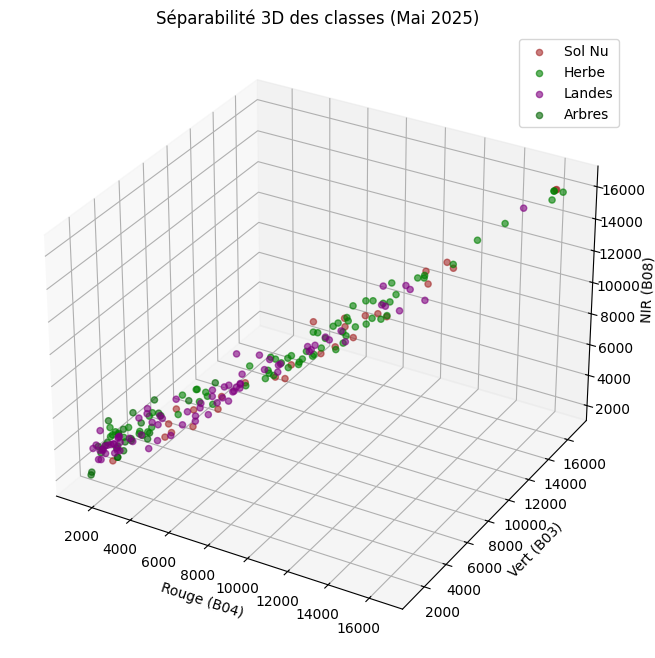

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# On choisit une date (Date 6 : 29 Mai 2025)
# B03 (Vert) -> idx 1. Date 6 -> Index 1*10 + 5 = 15 (pardon, date index 5 si on commence à 0, donc 15)
# B04 (Rouge) -> idx 2. Date 6 -> Index 25
# B08 (NIR)   -> idx 6. Date 6 -> Index 65
idx_vert = 15
idx_rouge = 25
idx_nir = 65

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for c in [1, 2, 3, 4]:
    mask = (Y == c)
    # Données x, y, z
    xs = X[mask, idx_rouge]
    ys = X[mask, idx_vert]
    zs = X[mask, idx_nir]
    
    ax.scatter(xs, ys, zs, c=colors[c], label=labels[c], s=20, alpha=0.6)

ax.set_xlabel('Rouge (B04)')
ax.set_ylabel('Vert (B03)')
ax.set_zlabel('NIR (B08)')
ax.set_title('Séparabilité 3D des classes (Mai 2025)')
plt.legend()

plt.savefig("results/figure/scatter_3d_RGB_NIR.png")
plt.show()

In [ ]:
import numpy as np
import os
from osgeo import gdal
from libsigma import read_and_write as rw

print("--- Production de la Carte Finale ---")

# 1. Configuration
# On reprend les mêmes listes que pour l'entraînement (TRÈS IMPORTANT : même ordre !)
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
base_dir = '/home/onyxia/work/data/projet_eval'
file_pattern = "pyrenees_24-25_{}.tif"
out_map_path = '/home/onyxia/work/projet_teledec/notebook/results/figure/carte_strates.tif'

# 2. Construction de la stack pour TOUTE l'image
# Attention : cela charge tout en RAM. Si l'image est immense, il faudrait le faire par blocs.
print("Chargement des données complètes...")

X_full_list = []
ref_ds = None # Pour garder les infos de géoréférencement

for b_name in band_names:
    fname = os.path.join(base_dir, file_pattern.format(b_name))
    
    # On garde le premier fichier comme référence pour la projection/taille
    if ref_ds is None:
        ref_ds = rw.open_image(fname)
        rows, cols = ref_ds.RasterYSize, ref_ds.RasterXSize
        print(f"Dimensions de l'image : {cols} x {rows} pixels")

    # Chargement de tout le fichier (H, W, 10_dates)
    img_arr = rw.load_img_as_array(fname)
    
    # On "aplatit" les dimensions spatiales (H*W, Dates)
    # img_arr.reshape(-1, img_arr.shape[2]) transforme (H, W, D) en (N_pixels, D)
    flat_arr = img_arr.reshape(-1, img_arr.shape[2])
    
    X_full_list.append(flat_arr)

# Concaténation des 100 features (10 fichiers * 10 dates)
X_full = np.concatenate(X_full_list, axis=1)

# Gestion des NaNs (remplacer par 0)
X_full = np.nan_to_num(X_full)

print(f"Données prêtes pour prédiction. Forme : {X_full.shape}")

# 3. Prédiction
print("Lancement de la prédiction (patience)...")
# best_clf est ton modèle optimisé à l'étape précédente
Y_full_pred = best_clf.predict(X_full)

# 4. Remise en forme (Reshape)
# On repasse de (N_pixels) à (Hauteur, Largeur)
map_pred = Y_full_pred.reshape(rows, cols)

# 5. Sauvegarde
print(f"Sauvegarde dans : {out_map_path}")

# On utilise write_image avec le dataset de référence pour copier la projection
# On force le type GDT_Byte (uint8) car les classes sont 1, 2, 3, 4
rw.write_image(out_map_path, map_pred.astype(np.uint8), data_set=ref_ds, gdal_dtype=gdal.GDT_Byte)

print("✅ Carte terminée !")

--- Production de la Carte Finale ---
Chargement des données complètes...
Dimensions de l'image : 2103 x 1655 pixels


Données prêtes pour prédiction. Forme : (3480465, 100)
Lancement de la prédiction (patience)...
Sauvegarde dans : /home/onyxia/work/projet_teledec/notebook/results/figure/carte_strates.tif
✅ Carte terminée !
